In [65]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

# hadgem 
hadgem = xr.open_dataset("/Users/julianschmitt/Downloads/HadGEM2-A_amip.2004-2008.07.nc", group = "site23")
# era5 forcing
era5 = xr.open_dataset("../era5_forcing_v2.nc", group = "site23")

In [66]:
# t = list(era5.data_vars)
# t.remove("z")
# t.remove("rho")
# t.remove("wa")
# t.remove("coszen")
# t.remove("ts")
# t.remove("rsdt")
# t
t= ["ta", "ua", "va", "hus", "wap", "tntva", "tnhusva", "tntha", "tnhusha"]
era5.z.mean(dim = "valid_time")

<xarray.DataArray 'z' (pressure_level: 37)> Size: 148B
array([  1308.3136,   3463.5276,   5658.901 ,   7898.6187,  10187.716 ,
        12537.87  ,  14961.083 ,  17451.4   ,  20008.455 ,  22634.373 ,
        25332.46  ,  30967.2   ,  36963.914 ,  43379.35  ,  50249.562 ,
        57650.59  ,  65682.695 ,  74457.96  ,  84166.4   ,  95034.87  ,
       107406.26  , 114321.45  , 121848.805 , 130129.984 , 139382.67  ,
       149931.47  , 162481.94  , 182763.56  , 202711.78  , 234255.95  ,
       260084.42  , 305479.78  , 329414.84  , 352556.88  , 388772.06  ,
       418595.84  , 470626.94  ], dtype=float32)
Coordinates:
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude        float64 8B ...
    longitude       float64 8B ...
    number          int64 8B ...
    lon             float32 4B ...
    lat             float32 4B ...
    site            int32 4B ...

In [58]:
hadgem.lev

<xarray.DataArray 'lev' (lev: 38)> Size: 304B
array([2.00000e+01, 8.00000e+01, 1.80000e+02, 3.20000e+02, 5.00000e+02,
       7.20000e+02, 9.80000e+02, 1.28000e+03, 1.62000e+03, 2.00000e+03,
       2.42000e+03, 2.88000e+03, 3.38000e+03, 3.92000e+03, 4.50000e+03,
       5.12000e+03, 5.78000e+03, 6.48000e+03, 7.22000e+03, 8.00000e+03,
       8.82000e+03, 9.68000e+03, 1.05800e+04, 1.15200e+04, 1.25000e+04,
       1.35200e+04, 1.45808e+04, 1.56946e+04, 1.68753e+04, 1.81386e+04,
       1.95030e+04, 2.09902e+04, 2.26261e+04, 2.44583e+04, 2.65836e+04,
       2.92191e+04, 3.29087e+04, 3.92548e+04])
Coordinates:
    lon      float32 4B ...
    lat      float32 4B ...
    site     int32 4B ...
  * lev      (lev) float64 304B 20.0 80.0 180.0 ... 3.291e+04 3.925e+04
Attributes:
    bounds:         lev_bnds
    units:          m
    axis:           Z
    positive:       up
    long_name:      hybrid height coordinate
    standard_name:  atmosphere_hybrid_height_coordinate
    formula:        z = a + b*orog
    formula_terms:  a: lev b: b orog: orog

In [62]:
era5

<xarray.Dataset> Size: 254kB
Dimensions:         (valid_time: 120, pressure_level: 37)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-0...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude        float64 8B ...
    longitude       float64 8B ...
    number          int64 8B ...
    expver          (valid_time) <U4 2kB ...
    lon             float32 4B ...
    lat             float32 4B ...
    site            int32 4B ...
Data variables: (12/17)
    z               (valid_time, pressure_level) float32 18kB 1.332e+03 ... 4...
    ta              (valid_time, pressure_level) float32 18kB 295.0 ... 262.3
    rho             (valid_time, pressure_level) float64 36kB 1.181 ... 0.001328
    ua              (valid_time, pressure_level) float32 18kB -4.907 ... -22.46
    va              (valid_time, pressure_level) float32 18kB -2.781 ... 0.2731
    wa              (valid_time, pressure_level) float32 18kB 0.02758 ... -0....
    ...              ...
    ts              (valid_time) float32 480B ...
    wap             (valid_time, pressure_level) float64 36kB 0.03257 ... -3....
    tntva           (valid_time, pressure_level) float32 18kB -2.751e-05 ... ...
    tnhusva         (valid_time, pressure_level) float32 18kB -7.212e-10 ... ...
    tntha           (valid_time, pressure_level) float32 18kB -4.434e-06 ... ...
    tnhusha         (valid_time, pressure_level) float32 18kB -2.204e-08 ... ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-05T09:34 GRIB to CDM+CF via cfgrib-0.9.1...

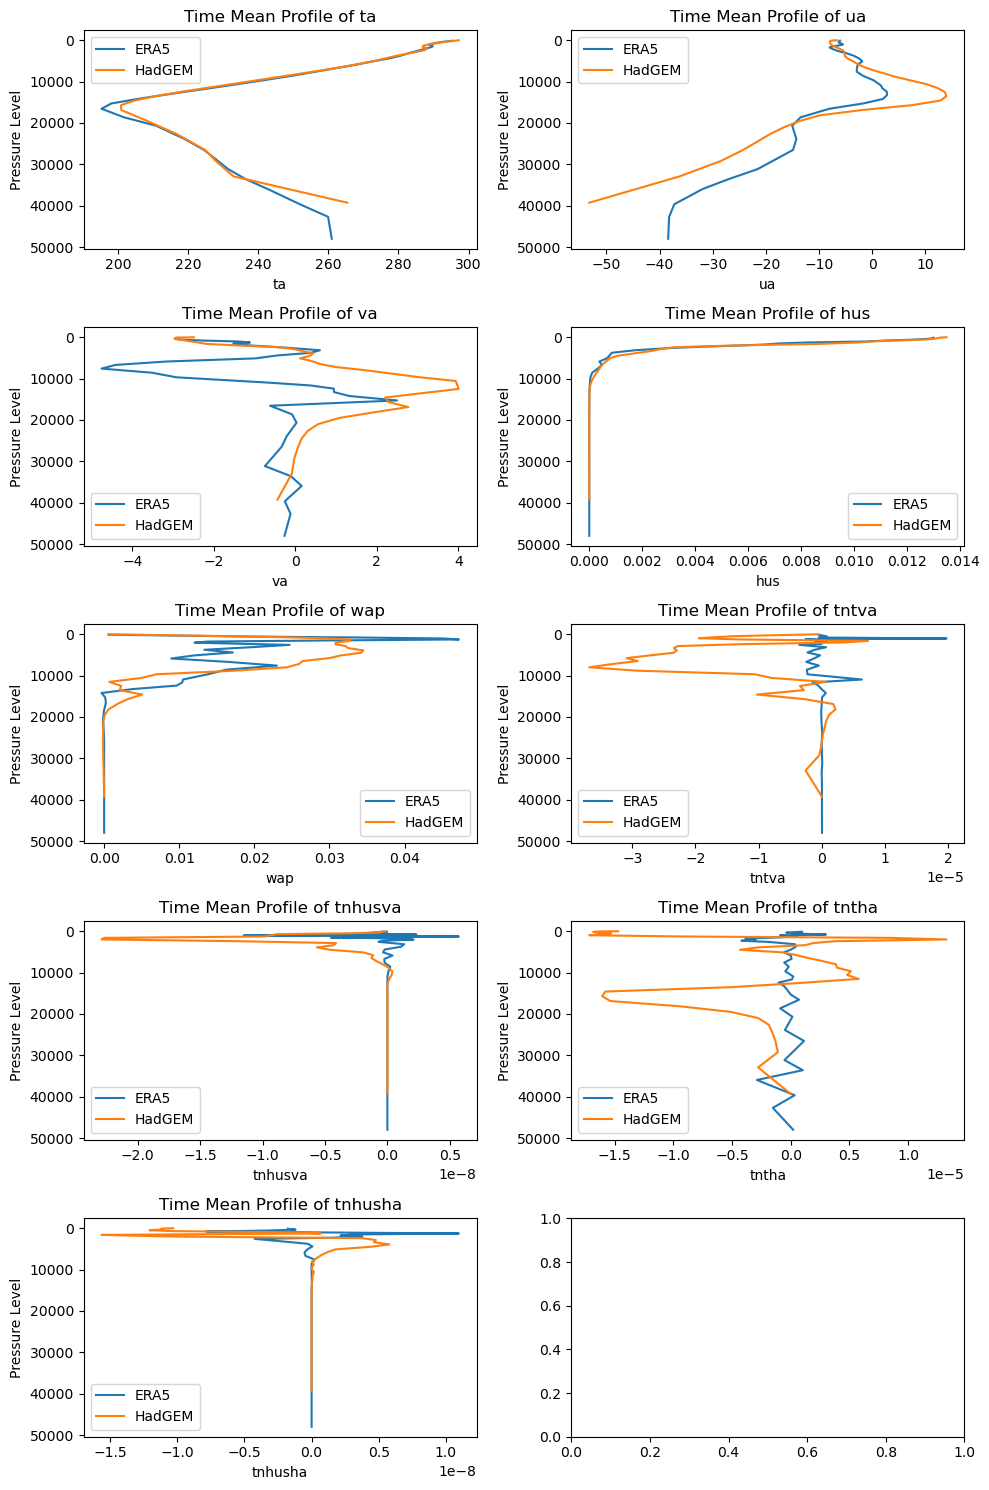

In [67]:
# plot time_mean profiles for hadgem and era5
fig, axes = plt.subplots(nrows=int(np.ceil(len(t)/2)), ncols=2, figsize=(10, 5 * 3))
axes = axes.flatten()
for ax, var in zip(axes, t):
    era5_mean = era5[var].mean(dim='valid_time')
    hadgem_mean = hadgem[var].mean(dim='time')
    
    ax.plot(era5_mean, era5.zg.mean(dim = "valid_time"), label='ERA5')
    ax.plot(hadgem_mean, hadgem["lev"], label='HadGEM')
    
    ax.set_title(f'Time Mean Profile of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Pressure Level')
    ax.invert_yaxis()
    ax.legend()

plt.tight_layout()
plt.show()